© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [56]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

In [57]:
num_classes = 2
sns.set(style='white', context="paper", font='Work Sans Regural', palette=sns.color_palette("colorblind"))
# palette=sns.color_palette(["#1F968BFF", "#FDE725FF", "#d1d3d4"], num_classes)

In [58]:
dataset = 'MIMIC'
models = [
    # os.path.join('SimCLR', dataset, '20230329-112506_l1_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.75.hdf5'),
    # os.path.join('SimCLR', dataset, '20230403-115302_200_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120645_e100_esFalse_bs128_wTrue_f2_fl', 'simclr.frozen.0.75.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120904_e100_esFalse_bs128_wTrue_f1_m', 'simclr.frozen.0.76.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121322_e100_esFalse_bs128_wTrue_f0', 'simclr.frozen.0.77.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121747_e100_esFalse_bs128_wTrue_f1', 'simclr.frozen.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122120_e100_esFalse_bs128_wTrue_f2', 'simclr.frozen.0.69.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122444_e100_esFalse_bs128_wTrue_f3', 'simclr.frozen.0.78.hdf5'),
    os.path.join('Supervised', dataset, '20230403-133103_l2_e100_esFalse_bs128_wTrue', 'supervised.finetuned.0.81.hdf5')
]
intermediate_layer = 7  # last CNN layer

In [59]:
model_file_name = models[-1]
model_name = 'sup'
xlim = (-5,5) if model_name == "sup" else (-10,10)
test = (np.load(os.path.join('SimCLR', dataset, 'test_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'test_y.npy')))

In [60]:
test_listfile = pd.read_csv(os.path.join('..', '..', 'datasets', dataset, 'test_listfile.csv'))
subjects = pd.read_csv(os.path.join('..', '..',  'datasets', dataset, 'demographics_rich.csv'))
# extract subject_id from stay
regex = r"(?:^\d+)"
test_listfile.loc[:, "SUBJECT_ID"] = test_listfile.stay.apply(lambda stay: re.search(regex, stay).group(0))
test_listfile.SUBJECT_ID = test_listfile.SUBJECT_ID.astype(int)
test_listfile.drop(['stay'], axis=1, inplace=True)
test_listfile = test_listfile.merge(subjects, how='left', on='SUBJECT_ID')
test_listfile.head()

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0


In [61]:
test_listfile.shape

(3236, 8)

In [62]:
# Get predictions and intermediate representation
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
# predictions
np_test = (np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_x.npy')),
           np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_y.npy')))
probs = model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
# representations
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(test[0], batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()

(3236, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

In [63]:
n, m = intermediate_representation.shape
intermediate_representation.shape

(3236, 96)

## PCA

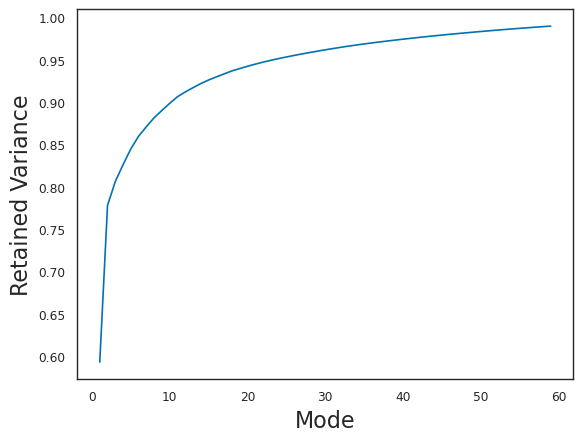

(3236, 59)


In [64]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.99, whiten=False)
embeds_pca = pca.fit_transform(intermediate_representation)

mu = pca.mean_
U = pca.components_.T
D = pca.singular_values_**2 / (n - 1)
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(range(1,len(exp_var)+1),np.cumsum(exp_var))
ax.set_xlabel('Mode', fontsize=16)
ax.set_ylabel('Retained Variance', fontsize=16)
plt.show()

test_listfile['PCA Mode 1'] = embeds_pca[:,0]
test_listfile['PCA Mode 2'] = embeds_pca[:,1]
test_listfile['PCA Mode 3'] = embeds_pca[:,2]
test_listfile['PCA Mode 4'] = embeds_pca[:,3]

print(embeds_pca.shape)

In [65]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,PCA Mode 1,PCA Mode 2,PCA Mode 3,PCA Mode 4
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,-1.045238,0.670504,0.166085,-0.123540
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,-0.754122,-0.080422,0.193750,0.034026
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.309305,-0.439804,0.005747,0.104216
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,-0.122593,-0.251649,0.165540,0.330425
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,-1.091063,1.297689,-0.102202,-0.095659
...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.072696,0.193411,0.092832,0.366059
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.689954,-0.771029,-0.073205,-0.071159
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.312837,0.545026,0.340015,-0.106915
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.166938,-0.439944,0.089552,-0.069186


In [66]:
print('Explained variance')
print(exp_var[:4])
print('Total (4 modes): {}'.format(sum(exp_var[:4])))

Explained variance
[0.593064 0.185217 0.028243 0.019904]
Total (4 modes): 0.8264281824231148


In [67]:
sum(exp_var)

0.9901238119928166

## t-SNE

In [68]:
from sklearn.manifold import TSNE
embeds_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42).fit_transform(embeds_pca)

test_listfile['t-SNE Dimension 1'] = embeds_tsne[:,0]
test_listfile['t-SNE Dimension 2'] = embeds_tsne[:,1]

In [69]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,PCA Mode 1,PCA Mode 2,PCA Mode 3,PCA Mode 4,t-SNE Dimension 1,t-SNE Dimension 2
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,-1.045238,0.670504,0.166085,-0.123540,-42.216560,-6.298601
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,-0.754122,-0.080422,0.193750,0.034026,-17.149719,-1.635270
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.309305,-0.439804,0.005747,0.104216,25.322800,-16.048820
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,-0.122593,-0.251649,0.165540,0.330425,-2.692647,-9.247515
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,-1.091063,1.297689,-0.102202,-0.095659,-57.438450,2.231129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.072696,0.193411,0.092832,0.366059,-5.890398,-28.728191
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.689954,-0.771029,-0.073205,-0.071159,30.969551,2.112046
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.312837,0.545026,0.340015,-0.106915,1.529464,9.370782
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.166938,-0.439944,0.089552,-0.069186,16.175566,14.901069


## Logits

In [70]:
probs[:,1]

array([0.613980, 0.324424, 0.100134, ..., 0.295769, 0.140670, 0.585980],
      dtype=float32)

In [71]:
test_listfile['Logit - Non-mortality'] = probs[:,0]
test_listfile['Logit - Mortality'] = probs[:,1]

In [72]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,PCA Mode 1,PCA Mode 2,PCA Mode 3,PCA Mode 4,t-SNE Dimension 1,t-SNE Dimension 2,Logit - Non-mortality,Logit - Mortality
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,-1.045238,0.670504,0.166085,-0.123540,-42.216560,-6.298601,0.386020,0.613980
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,-0.754122,-0.080422,0.193750,0.034026,-17.149719,-1.635270,0.675576,0.324424
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.309305,-0.439804,0.005747,0.104216,25.322800,-16.048820,0.899866,0.100134
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,-0.122593,-0.251649,0.165540,0.330425,-2.692647,-9.247515,0.819516,0.180484
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,-1.091063,1.297689,-0.102202,-0.095659,-57.438450,2.231129,0.238280,0.761719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.072696,0.193411,0.092832,0.366059,-5.890398,-28.728191,0.747040,0.252960
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.689954,-0.771029,-0.073205,-0.071159,30.969551,2.112046,0.942554,0.057446
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.312837,0.545026,0.340015,-0.106915,1.529464,9.370782,0.704231,0.295769
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.166938,-0.439944,0.089552,-0.069186,16.175566,14.901069,0.859330,0.140670


## Sampling

In [73]:
n_samples = 500

# GENDER
df_male = test_listfile[test_listfile['GENDER'] == "M"].sample(n=n_samples)
df_female = test_listfile[test_listfile['GENDER'] == "F"].sample(n=n_samples)
sample_test_gender = pd.concat([df_male, df_female])
sample_test_gender = sample_test_gender.sample(frac=1) # shuffle data for unbiased visualisation
sample_test_gender.reset_index(inplace=True, drop=True)

# ETHNICITY
df_white = test_listfile[test_listfile['ETHNICITY'].str.contains("WHITE")].sample(n=n_samples)
df_black = test_listfile[test_listfile['ETHNICITY'].str.contains("BLACK")].sample(n=n_samples, replace=True)
df_hispanic = test_listfile[test_listfile['ETHNICITY'].str.contains("HISPANIC")].sample(n=n_samples, replace=True)
df_asian = test_listfile[test_listfile['ETHNICITY'].str.contains("ASIAN")].sample(n=n_samples, replace=True)
sample_test = pd.concat([df_white, df_black, df_hispanic, df_asian])
sample_test = sample_test.sample(frac=1) # shuffle data for unbiased visualisation
sample_test.reset_index(inplace=True, drop=True)

# AGE
# df_l65 = test_listfile[test_listfile['AGE'] == 1].sample(n=n_samples)
# df_ge65 = test_listfile[test_listfile['AGE'] == 0].sample(n=n_samples)
# sample_test_age = pd.concat([df_l65, df_ge65])
# sample_test_age = sample_test_age.sample(frac=1) # shuffle data for unbiased visualisation

# INSURANCE
df_medicare = test_listfile[test_listfile['INSURANCE'] == "Medicare"].sample(n=n_samples)
df_medicaid = test_listfile[test_listfile['INSURANCE'] == "Medicaid"].sample(n=n_samples, replace=True)
df_private = test_listfile[test_listfile['INSURANCE'] == "Private"].sample(n=n_samples)
df_government = test_listfile[test_listfile['INSURANCE'] == "Government"].sample(n=n_samples, replace=True)
df_selfpay = test_listfile[test_listfile['INSURANCE'] == "Self Pay"].sample(n=n_samples, replace=True)
sample_test_insurance = pd.concat([df_medicaid, df_selfpay, df_government, df_medicare, df_private])
sample_test_insurance = sample_test_insurance.sample(frac=1) # shuffle data for unbiased visualisation

# LANGUAGE
# df_eng = test_listfile[test_listfile['LANGUAGE'] == "ENGL"].sample(n=n_samples)
# df_other = test_listfile[test_listfile['LANGUAGE'] == "OTHER"].sample(n=n_samples)

## Visualizing logits

In [74]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,PCA Mode 1,PCA Mode 2,PCA Mode 3,PCA Mode 4,t-SNE Dimension 1,t-SNE Dimension 2,Logit - Non-mortality,Logit - Mortality
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,-1.045238,0.670504,0.166085,-0.123540,-42.216560,-6.298601,0.386020,0.613980
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,-0.754122,-0.080422,0.193750,0.034026,-17.149719,-1.635270,0.675576,0.324424
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.309305,-0.439804,0.005747,0.104216,25.322800,-16.048820,0.899866,0.100134
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,-0.122593,-0.251649,0.165540,0.330425,-2.692647,-9.247515,0.819516,0.180484
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,-1.091063,1.297689,-0.102202,-0.095659,-57.438450,2.231129,0.238280,0.761719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.072696,0.193411,0.092832,0.366059,-5.890398,-28.728191,0.747040,0.252960
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.689954,-0.771029,-0.073205,-0.071159,30.969551,2.112046,0.942554,0.057446
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.312837,0.545026,0.340015,-0.106915,1.529464,9.370782,0.704231,0.295769
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.166938,-0.439944,0.089552,-0.069186,16.175566,14.901069,0.859330,0.140670


In [75]:
alpha = 0.6
style = 'o'
markersize = 40
kind = 'scatter'
rasterized_scatter = True
out_format = 'pdf'

method = 'logit'
xdat = 'Logit - Non-mortality'
ydat = 'Logit - Mortality'

In [76]:
test_listfile.loc[:, 'Outcome'] = test_listfile.loc[:, 'y_true'].apply(lambda v: 'Mortality' if v==1 else 'Non-mortality')
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,PCA Mode 1,PCA Mode 2,PCA Mode 3,PCA Mode 4,t-SNE Dimension 1,t-SNE Dimension 2,Logit - Non-mortality,Logit - Mortality,Outcome
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,-1.045238,0.670504,0.166085,-0.123540,-42.216560,-6.298601,0.386020,0.613980,Mortality
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,-0.754122,-0.080422,0.193750,0.034026,-17.149719,-1.635270,0.675576,0.324424,Non-mortality
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.309305,-0.439804,0.005747,0.104216,25.322800,-16.048820,0.899866,0.100134,Non-mortality
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,-0.122593,-0.251649,0.165540,0.330425,-2.692647,-9.247515,0.819516,0.180484,Non-mortality
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,-1.091063,1.297689,-0.102202,-0.095659,-57.438450,2.231129,0.238280,0.761719,Non-mortality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.072696,0.193411,0.092832,0.366059,-5.890398,-28.728191,0.747040,0.252960,Non-mortality
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.689954,-0.771029,-0.073205,-0.071159,30.969551,2.112046,0.942554,0.057446,Non-mortality
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.312837,0.545026,0.340015,-0.106915,1.529464,9.370782,0.704231,0.295769,Non-mortality
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.166938,-0.439944,0.089552,-0.069186,16.175566,14.901069,0.859330,0.140670,Non-mortality


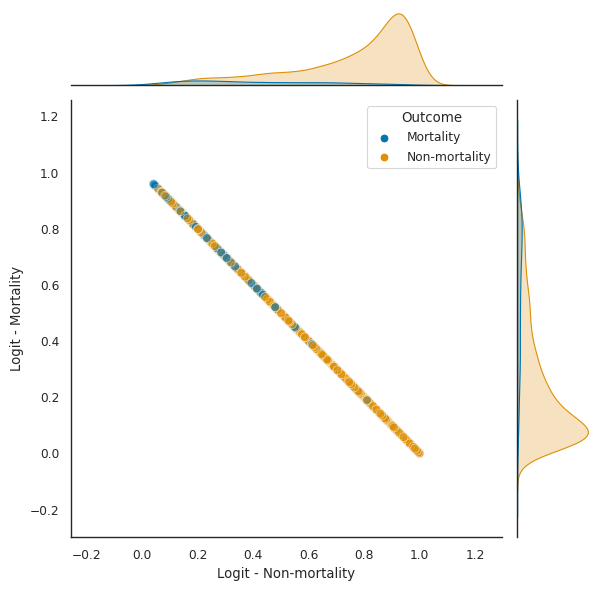

In [77]:
label = 'Outcome'
num_classes = 2
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
# plt.savefig(method + '-' + model + '-disease.' + out_format, bbox_inches='tight', dpi=300)
plt.savefig(os.path.join("results", dataset, "pca", "logits-{}-mortality.{}".format(model_name,out_format)), bbox_inches='tight')
# fig.ax_joint.legend(loc='upper right')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

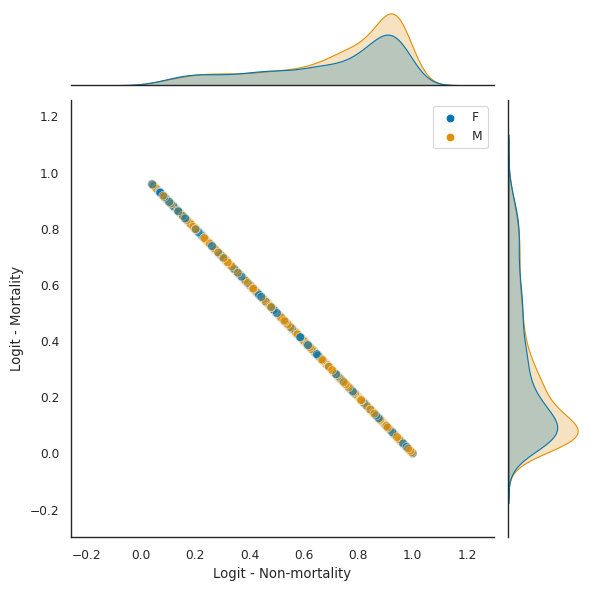

In [78]:
label = 'GENDER'
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "logits-{}-gender.{}".format(model_name,out_format)), bbox_inches='tight')

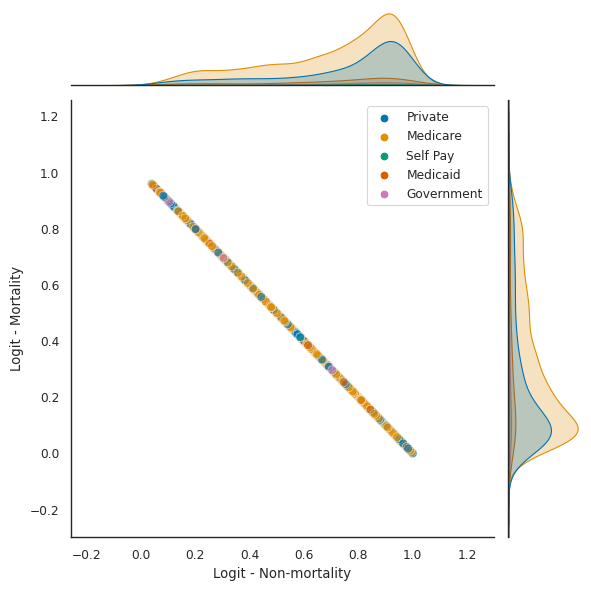

In [79]:
label = 'INSURANCE'
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "logits-{}-insurance.{}".format(model_name,out_format)), bbox_inches='tight')

In [80]:
test_listfile['ETHNICITY (GROUPED)'] = test_listfile.ETHNICITY.apply(lambda v: "WHITE" if "WHITE" in v else ("BLACK" if "BLACK" in v else ("HISPANIC" if "HISPANIC" in v else ("ASIAN" if "ASIAN" in v else "OTHER"))))
test_listfile['ETHNICITY (GROUPED)'].value_counts()

WHITE       2330
OTHER        439
BLACK        293
HISPANIC     111
ASIAN         63
Name: ETHNICITY (GROUPED), dtype: int64

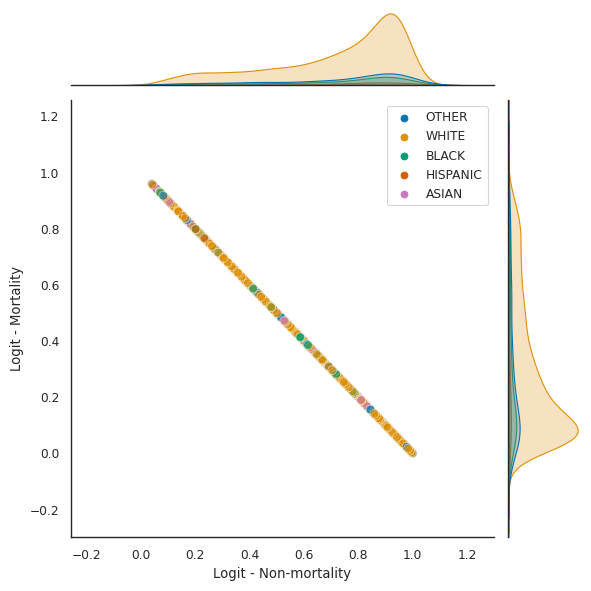

In [81]:
label = 'ETHNICITY (GROUPED)'
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "logits-{}-ethnicity.{}".format(model_name,out_format)), bbox_inches='tight')

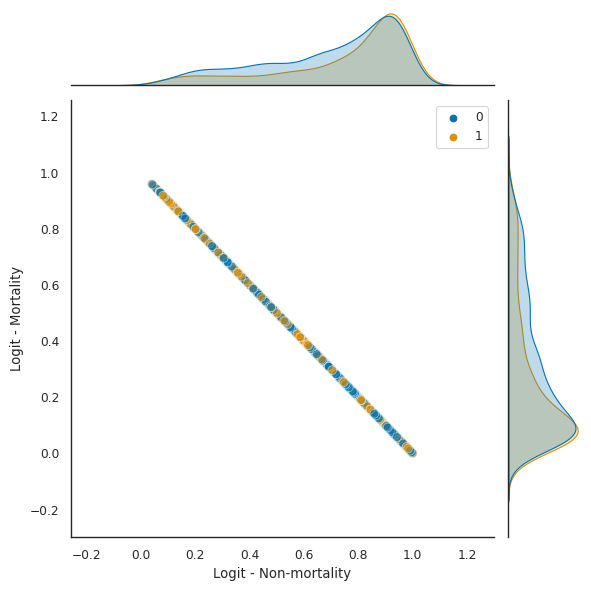

In [82]:
label = 'AGE'
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "logits-{}-age.{}".format(model_name,out_format)), bbox_inches='tight')

## Visualizing t-SNE

In [83]:
xdat = 't-SNE Dimension 1'
ydat = 't-SNE Dimension 2'

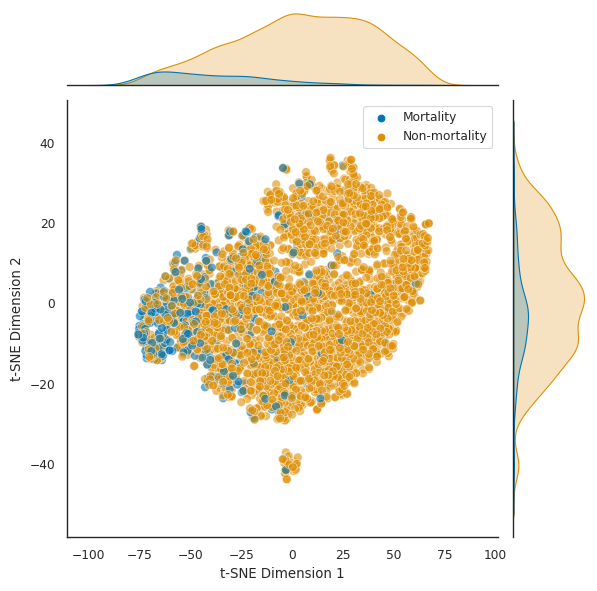

In [84]:
label = 'Outcome'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-disease.' + out_format, bbox_inches='tight', dpi=300)
plt.savefig(os.path.join("results", dataset, "pca", "tsne-{}-mortality.{}".format(model_name,out_format)), bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

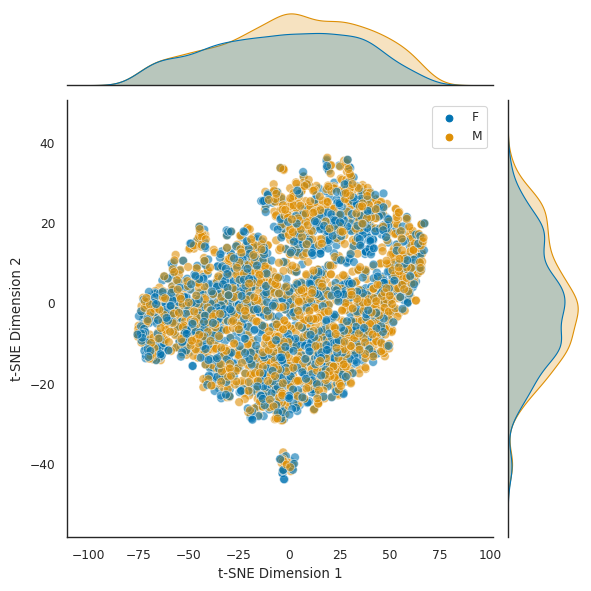

In [85]:
label = 'GENDER'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "tsne-{}-gender.{}".format(model_name,out_format)), bbox_inches='tight')

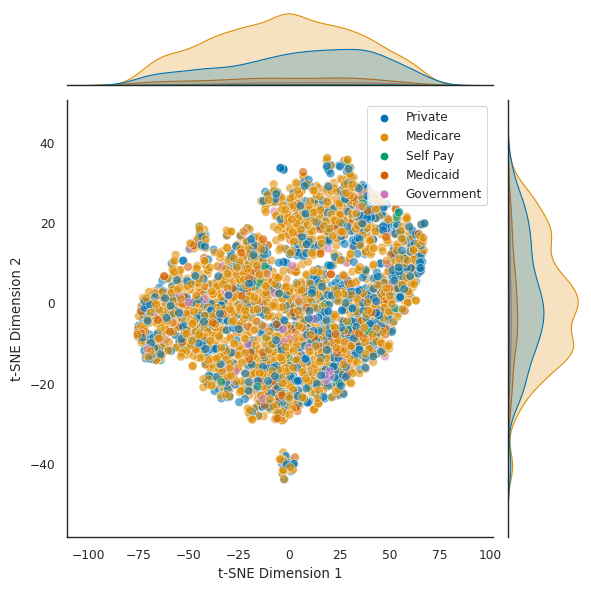

In [86]:
label = 'INSURANCE'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "tsne-{}-insurance.{}".format(model_name,out_format)), bbox_inches='tight')

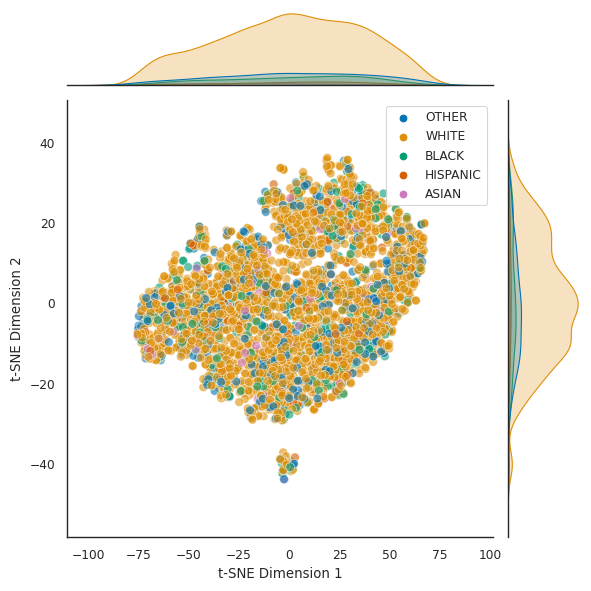

In [87]:
label = 'ETHNICITY (GROUPED)'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "tsne-{}-ethincity.{}".format(model_name,out_format)), bbox_inches='tight')

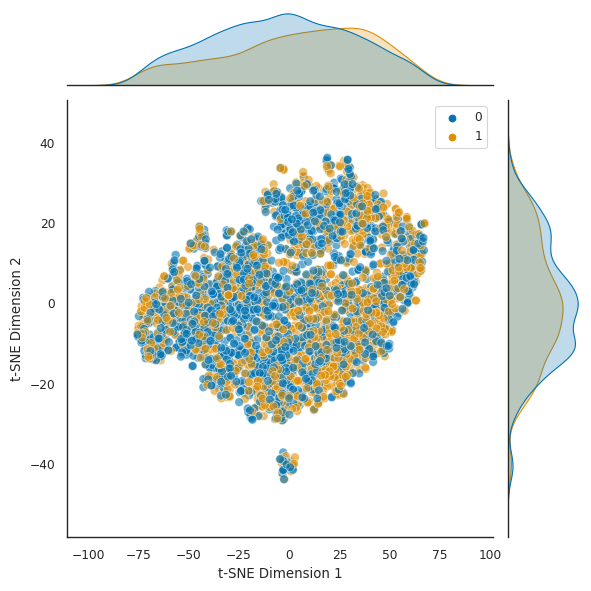

In [88]:
label = 'AGE'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "tsne-{}-age.{}".format(model_name,out_format)), bbox_inches='tight')

## Visualizing PCA
### Modes 1+2

In [89]:
method = 'pca'
xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'
if model_name == 'ssl':
    xlim=(-15,15)
    ylim=(-15,15)
else:
    xlim=(-5,5)
    ylim=(-2,4)

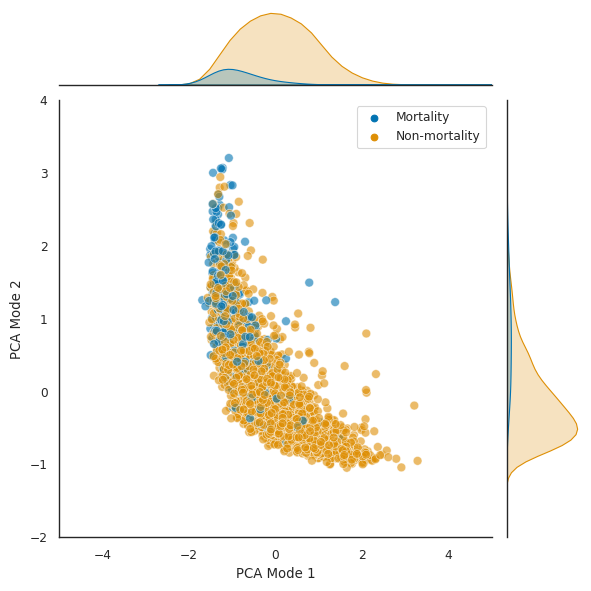

In [90]:
label = 'Outcome'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-mortality-mode-1+2.{}".format(model_name,out_format)), bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

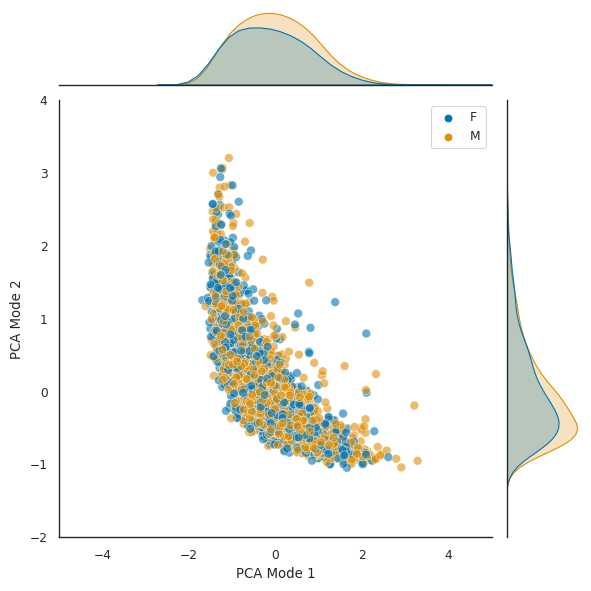

In [91]:
label = 'GENDER'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-gender-mode-1+2.{}".format(model_name,out_format)), bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

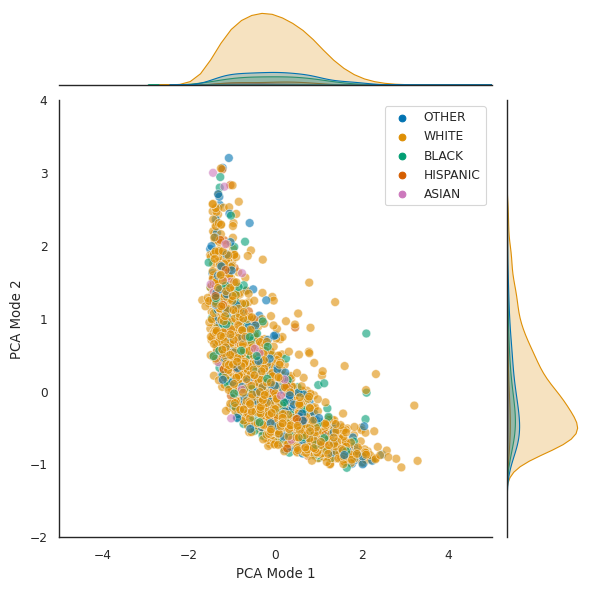

In [92]:
label = 'ETHNICITY (GROUPED)'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-ethnicity-mode-1+2.{}".format(model_name,out_format)), bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

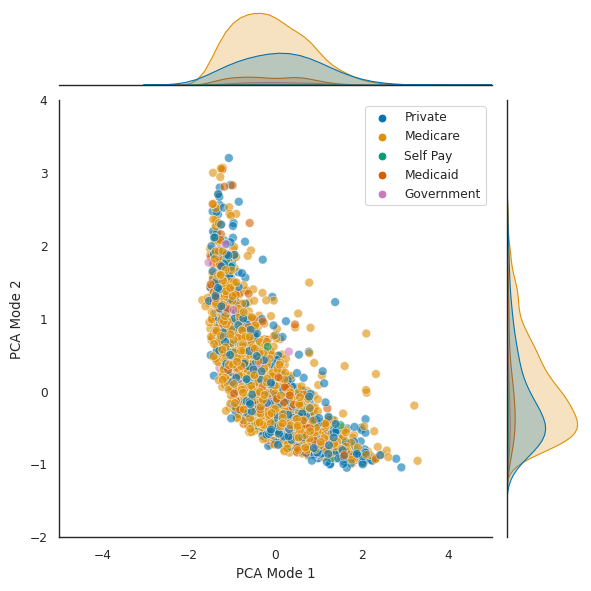

In [93]:
label = 'INSURANCE'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile, joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-insurance-mode-1+2.{}".format(model_name,out_format)), bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

### Modes 3+4

In [94]:
method = 'pca'
xdat = 'PCA Mode 3'
ydat = 'PCA Mode 4'

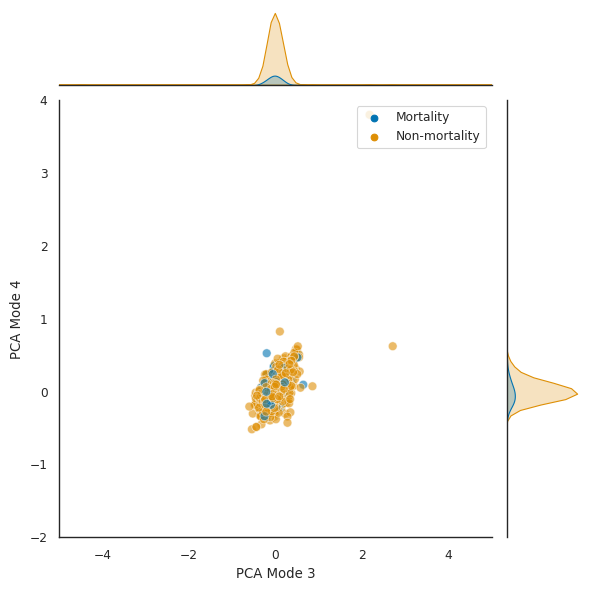

In [95]:
label = 'Outcome'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile,
                    joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
# sup xlim=(-1.5,1.5), ylim=(-1,1)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-mortality-mode-3+4.{}".format(model_name, out_format)),
            bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

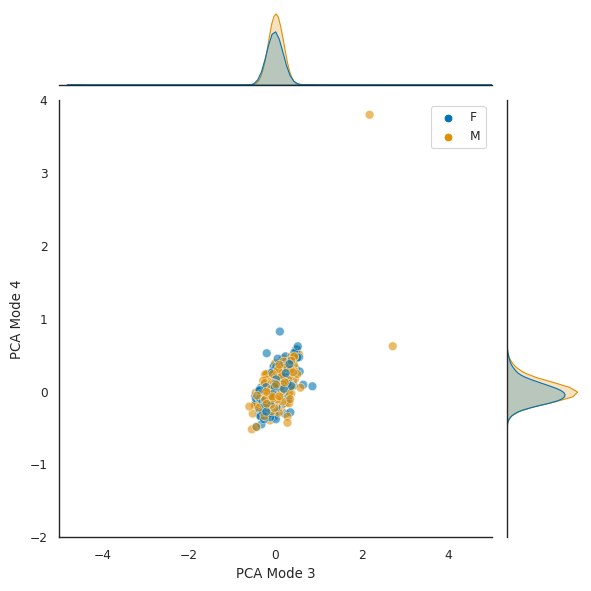

In [96]:
label = 'GENDER'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile,
                    joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-gender-mode-3+4.{}".format(model_name, out_format)),
            bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

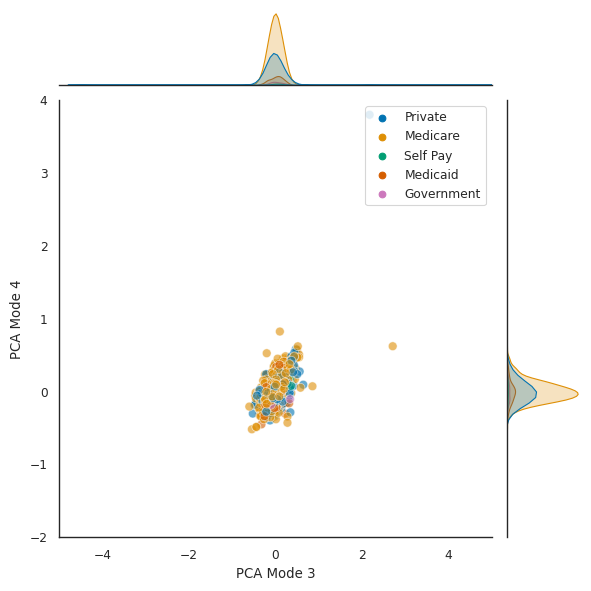

In [97]:
label = 'INSURANCE'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile,
                    joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-insurance-mode-3+4.{}".format(model_name, out_format)),
            bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

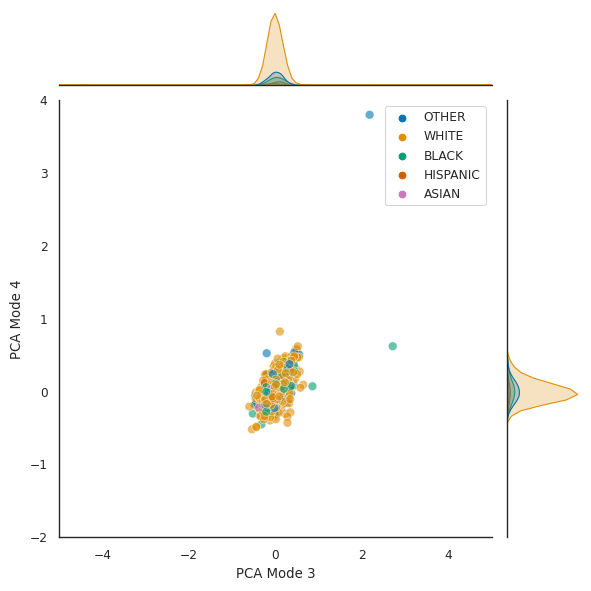

In [98]:
label = 'ETHNICITY (GROUPED)'

fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, data=test_listfile,
                    joint_kws=dict(rasterized=rasterized_scatter), xlim=xlim, ylim=ylim)
fig.ax_joint.legend(loc='upper right')
plt.savefig(os.path.join("results", dataset, "pca", "pca-{}-ethnicity-mode-3+4.{}".format(model_name, out_format)),
            bbox_inches='tight')
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

## Statistical Tests

In [99]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})

In [100]:
test_listfile.columns

Index(['y_true', 'SUBJECT_ID', 'LANGUAGE', 'INSURANCE', 'RELIGION',
       'ETHNICITY', 'GENDER', 'AGE', 'PCA Mode 1', 'PCA Mode 2', 'PCA Mode 3',
       'PCA Mode 4', 't-SNE Dimension 1', 't-SNE Dimension 2',
       'Logit - Non-mortality', 'Logit - Mortality', 'Outcome',
       'ETHNICITY (GROUPED)'],
      dtype='object')

In [107]:
def stats_tests(marginal, samples):
    # ethnicity
    df_white = samples[samples['ETHNICITY (GROUPED)'] == "WHITE"]
    df_asian = samples[samples['ETHNICITY (GROUPED)'] == "ASIAN"]
    df_black = samples[samples['ETHNICITY (GROUPED)'] == "BLACK"]
    df_hispanic = samples[samples['ETHNICITY (GROUPED)'] == "HISPANIC"]
    df_other = samples[samples['ETHNICITY (GROUPED)'] == "OTHER"]
    # gender
    df_female = samples[samples['GENDER'] == "F"]
    df_male = samples[samples['GENDER'] == "M"]
    # insurance
    df_medicare = samples[samples['INSURANCE'] == "Medicare"]
    df_medicaid = samples[samples['INSURANCE'] == "Medicaid"]
    df_private = samples[samples['INSURANCE'] == "Private"]
    df_government = samples[samples['INSURANCE'] == "Government"]
    df_selfpay= samples[samples['INSURANCE'] == "Self Pay"]
    # label
    df_nomortality = samples[samples['y_true'] == 0]
    df_mortality = samples[samples['y_true'] == 1]

    res_nm = stats.ks_2samp(np.array(df_nomortality[marginal]), np.array(df_mortality[marginal]))
    res_ab = stats.ks_2samp(np.array(df_asian[marginal]), np.array(df_black[marginal]))
    res_wb = stats.ks_2samp(np.array(df_white[marginal]), np.array(df_black[marginal]))
    res_hb = stats.ks_2samp(np.array(df_hispanic[marginal]), np.array(df_black[marginal]))
    res_ob = stats.ks_2samp(np.array(df_other[marginal]), np.array(df_black[marginal]))
    res_mf = stats.ks_2samp(np.array(df_female[marginal]), np.array(df_male[marginal]))
    
    res_mm = stats.ks_2samp(np.array(df_medicaid[marginal]), np.array(df_medicare[marginal]))
    res_mp = stats.ks_2samp(np.array(df_medicaid[marginal]), np.array(df_private[marginal]))
    res_ms = stats.ks_2samp(np.array(df_medicaid[marginal]), np.array(df_selfpay[marginal]))
    res_mg = stats.ks_2samp(np.array(df_medicaid[marginal]), np.array(df_government[marginal]))

    return [res_nm.pvalue, res_ab.pvalue, res_wb.pvalue, res_hb.pvalue, res_ob.pvalue, res_mf.pvalue, res_mm.pvalue, res_mp.pvalue, res_ms.pvalue, res_mg.pvalue]

In [102]:
pvals_pca1 = stats_tests('PCA Mode 1', test_listfile)
pvals_pca2 = stats_tests('PCA Mode 2', test_listfile)
pvals_pca3 = stats_tests('PCA Mode 3', test_listfile)
pvals_pca4 = stats_tests('PCA Mode 4', test_listfile)
pvals_log0 = stats_tests('Logit - Non-mortality', test_listfile)
pvals_log1 = stats_tests('Logit - Mortality', test_listfile)
pvals = np.array([pvals_pca1, pvals_pca2, pvals_pca3, pvals_pca4, pvals_log0, pvals_log1])
res = multipletests(pvals.flatten(), alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)

In [106]:
print('Rejected null hypothesis')
print(np.array(res[0]).reshape((6,10)))


### SSL
Rejected null hypothesis
[[ True False False False False False False False False False]
 [ True False False False False  **True** False False False False]
 [ True False False False False False False False False False]
 [ True False False False False False False False False False]
 [ True False False False False False False False False False]
 [ True False False False False False False False False False]]
 
Apart from the label, the only difference in distributions is observed for males vs females in PCA2

### Supervised
Rejected null hypothesis
[[ True  **True** False False False  **True** False False False False]
 [ True False False False False False False False False False]
 [False False False False False False False False False False]
 [ True False False False False  **True** False False False False]
 [ True  **True** False False False  **True** False  **True** False False]
 [ True  **True** False False False  **True** False  **True** False False]]
 
Apart from the label, the differences in distributions lie in:
PCA 1: Asian-Black, Male-Female
PCA 4: Male-Female
Non-mortality: Asian-Black, Male-Female, Medicaid-Private
Mortality: Asian-Black, Male-Female, Medicaid-Private


In [104]:
print('Adjusted p-values')
print(np.array(res[1]).reshape((6,10)))

Adjusted p-values
[[0.000000 0.024831 1.000000 1.000000 1.000000 0.011687 1.000000 0.079027
  1.000000 1.000000]
 [0.000000 0.271978 1.000000 1.000000 1.000000 0.152718 1.000000 0.179672
  1.000000 1.000000]
 [1.000000 1.000000 0.110513 1.000000 1.000000 1.000000 0.885828 0.425548
  1.000000 1.000000]
 [0.010643 1.000000 0.054717 1.000000 1.000000 0.012893 1.000000 1.000000
  1.000000 1.000000]
 [0.000000 0.012597 1.000000 1.000000 1.000000 0.006967 1.000000 0.034735
  1.000000 1.000000]
 [0.000000 0.012597 1.000000 1.000000 1.000000 0.006967 1.000000 0.034735
  1.000000 1.000000]]


## KDE Visualizations

### PCA 1

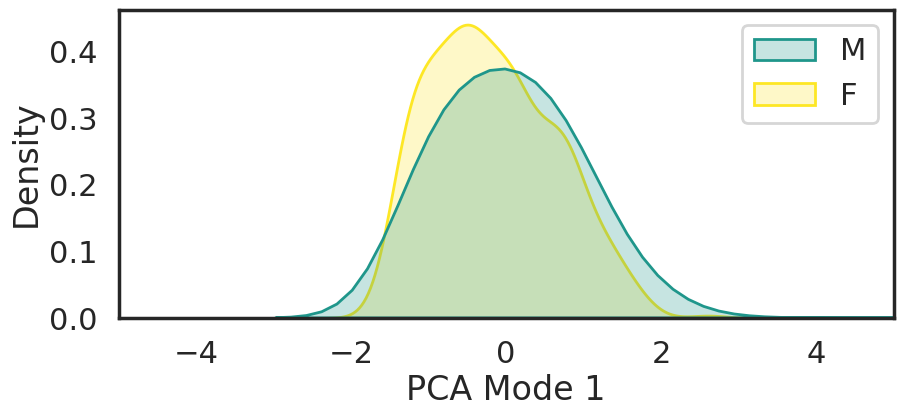

In [104]:
xdat = 'PCA Mode 1'
label = "GENDER"
fig, ax = plt.subplots(figsize=(10,4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=['M', 'F'], data=sample_test_gender, ax=ax, common_norm=False)
g.get_legend().set_title(None)
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-1-{}-{}-marginal.pdf".format(model_name, label)), bbox_inches='tight')

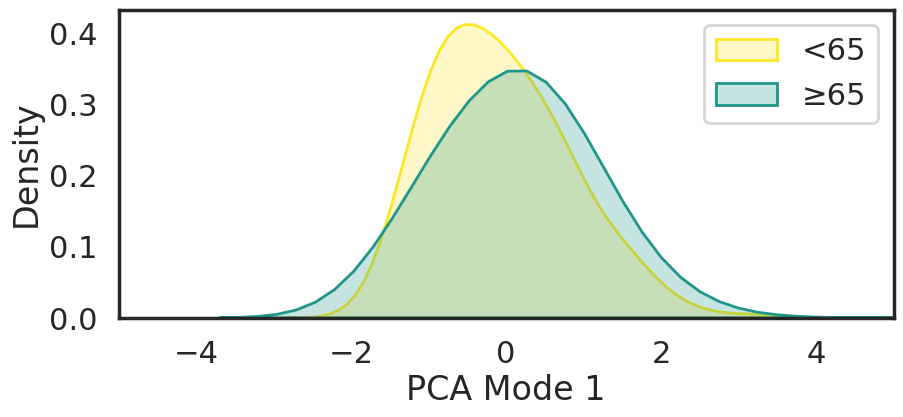

In [83]:
label = "AGE"
fig, ax = plt.subplots(figsize=(10,4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=[1, 0], data=sample_test_age, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["<65", "≥65"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-1-{}-{}-marginal.pdf".format(model_name, label)), bbox_inches='tight')

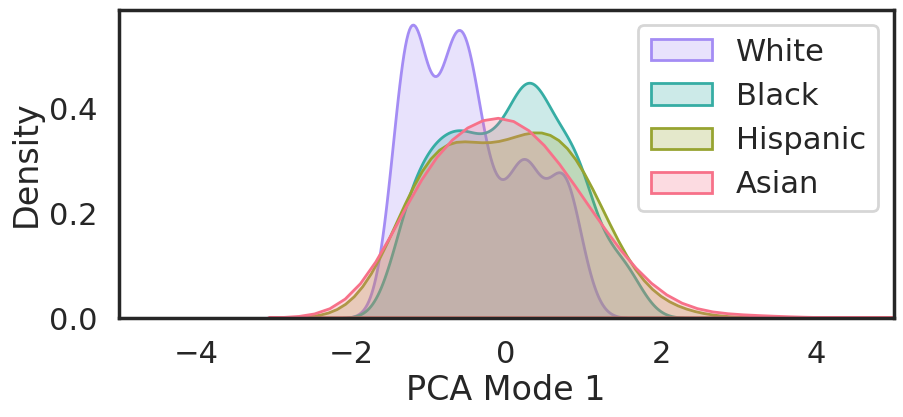

In [84]:
label = "ETHNICITY"
fig, ax = plt.subplots(figsize=(10,4))
sample_test_ethnicity.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=["WHITE", "BLACK/AFRICAN AMERICAN", "HISPANIC OR LATINO", "ASIAN"], data=sample_test_ethnicity, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-1-{}-{}-marginal.pdf".format(model_name, label)), bbox_inches='tight')

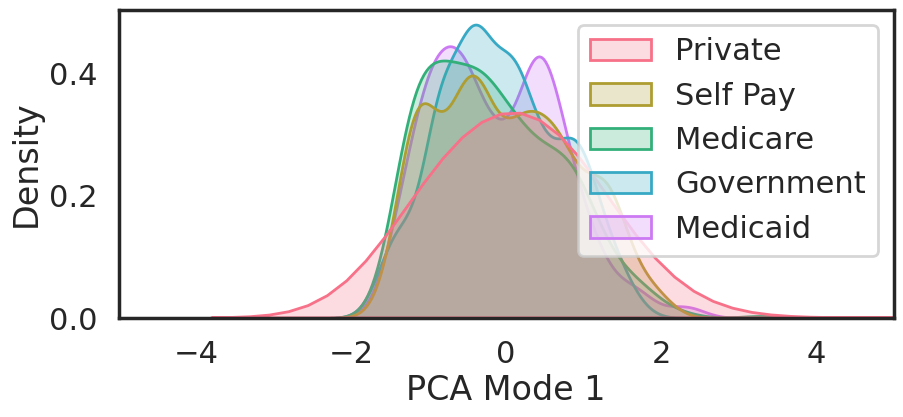

In [85]:
label = "INSURANCE"
fig, ax = plt.subplots(figsize=(10,4))
sample_test_insurance.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True, data=sample_test_insurance, ax=ax, common_norm=False)
g.get_legend().set_title(None)
# ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-1-{}-{}-marginal.pdf".format(model_name, label)), bbox_inches='tight')

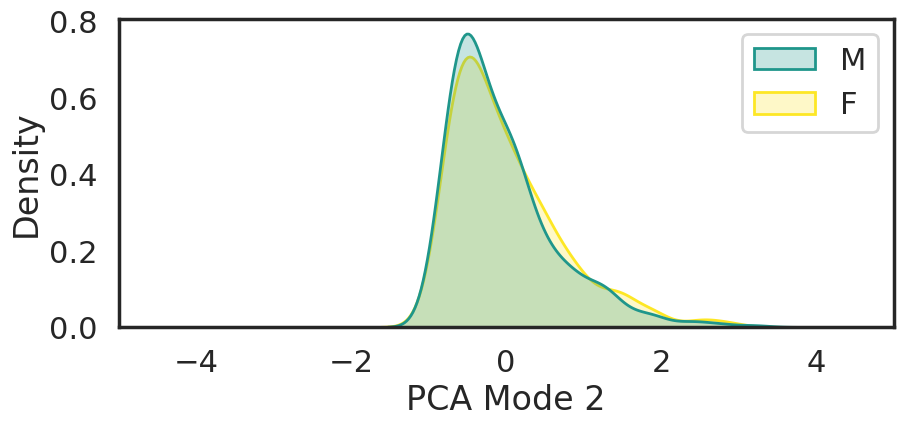

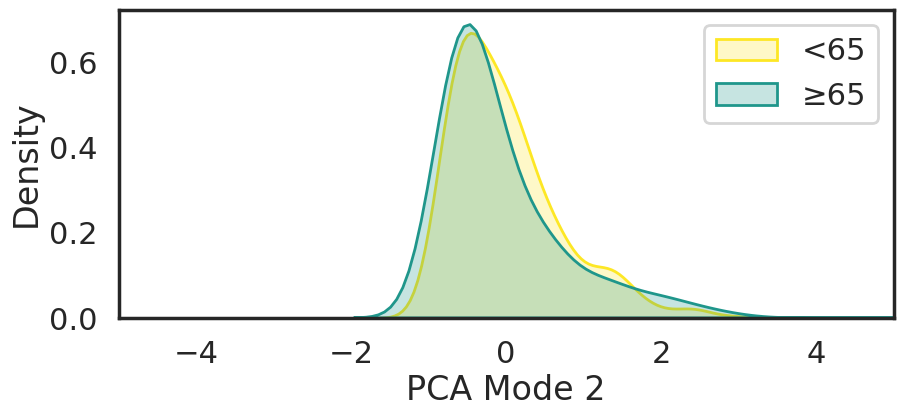

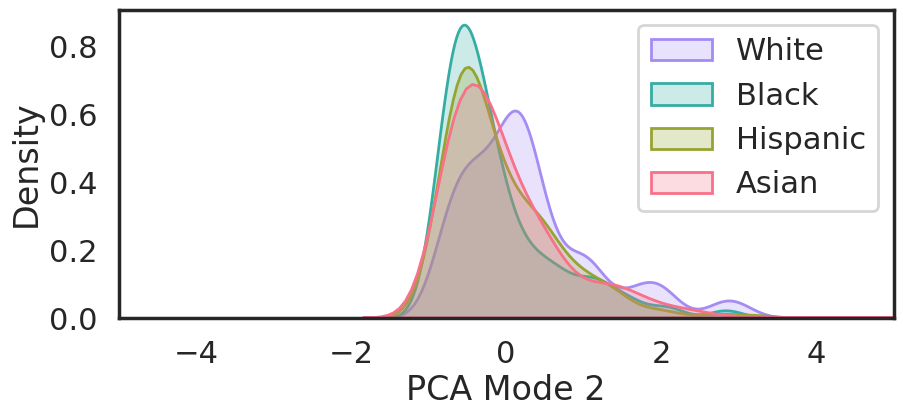

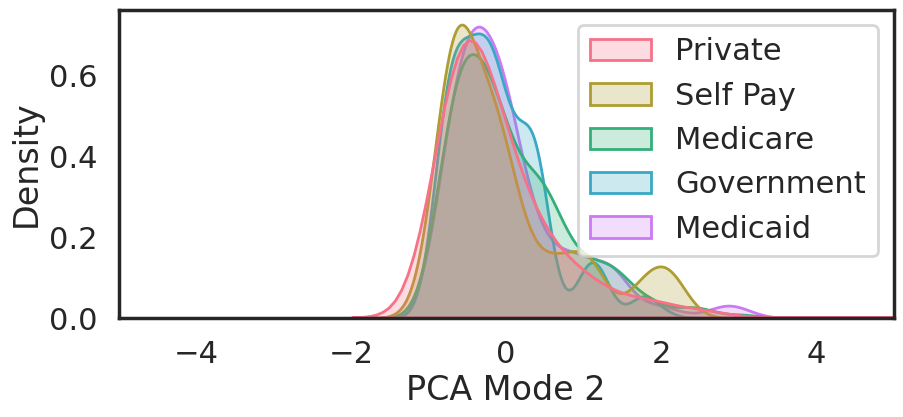

In [86]:
### PCA 2
xdat = 'PCA Mode 2'
label = "GENDER"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=['M', 'F'], data=sample_test_gender, ax=ax, common_norm=False)
g.get_legend().set_title(None)
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-2-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "AGE"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=[1, 0], data=sample_test_age, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["<65", "≥65"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-2-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "ETHNICITY"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_ethnicity.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True,
                hue_order=["WHITE", "BLACK/AFRICAN AMERICAN", "HISPANIC OR LATINO", "ASIAN"],
                data=sample_test_ethnicity, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-2-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "INSURANCE"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_insurance.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True, data=sample_test_insurance, ax=ax, common_norm=False)
g.get_legend().set_title(None)
# ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-2-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

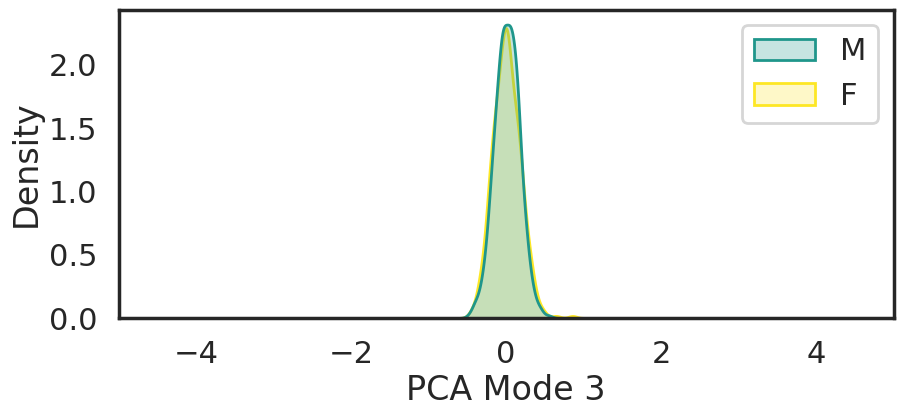

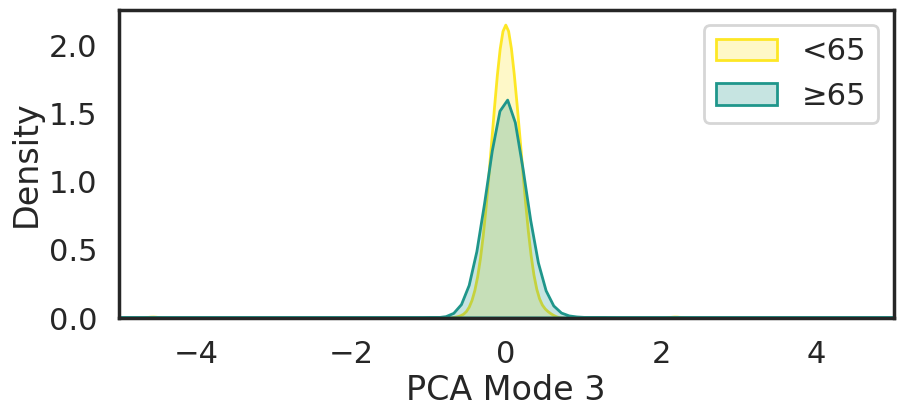

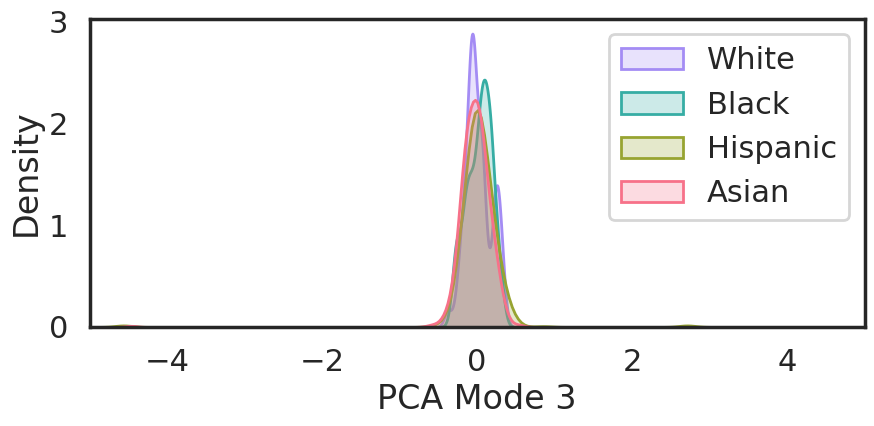

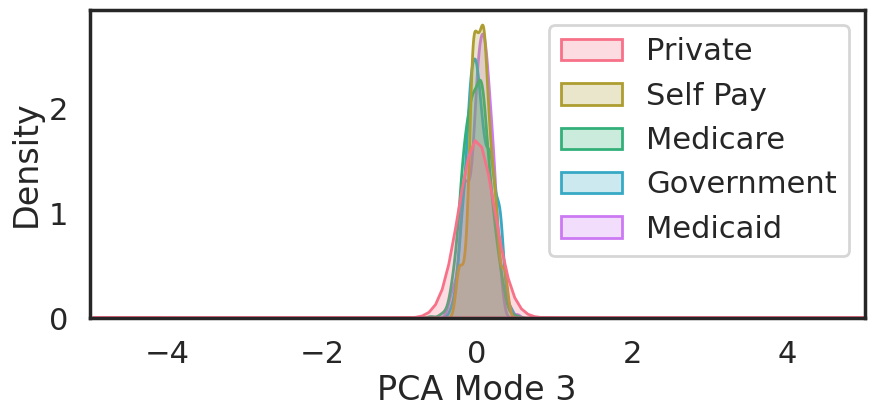

In [87]:
### PCA 2
xdat = 'PCA Mode 3'
label = "GENDER"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=['M', 'F'], data=sample_test_gender, ax=ax, common_norm=False)
g.get_legend().set_title(None)
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-3-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "AGE"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=[1, 0], data=sample_test_age, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["<65", "≥65"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-3-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "ETHNICITY"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_ethnicity.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True,
                hue_order=["WHITE", "BLACK/AFRICAN AMERICAN", "HISPANIC OR LATINO", "ASIAN"],
                data=sample_test_ethnicity, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-3-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "INSURANCE"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_insurance.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True, data=sample_test_insurance, ax=ax, common_norm=False)
g.get_legend().set_title(None)
# ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-3-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

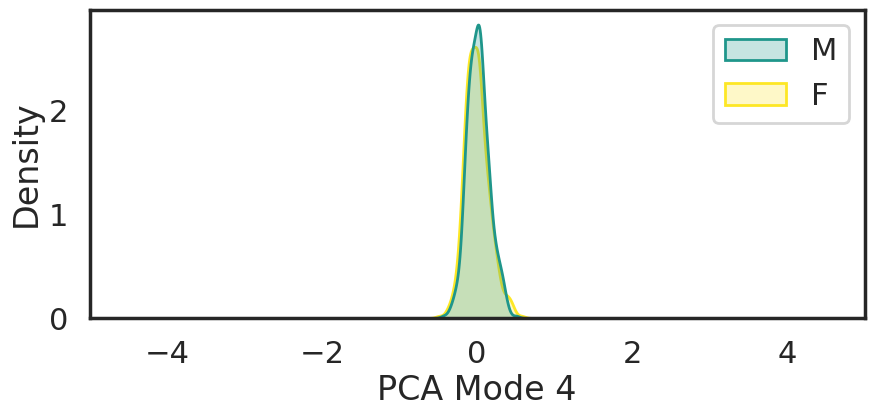

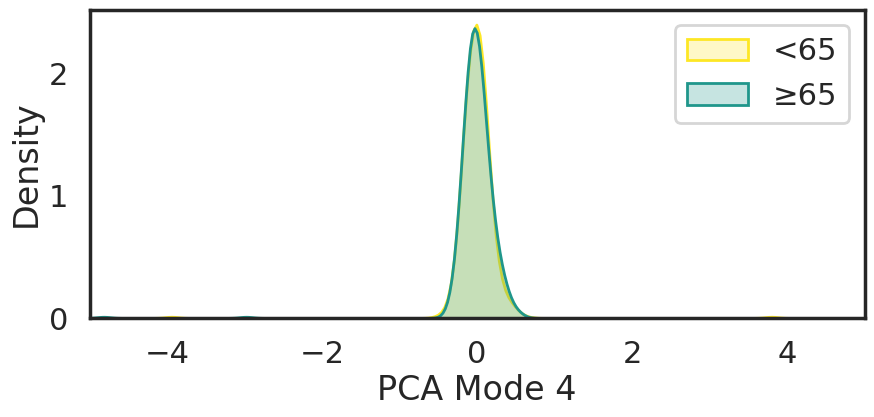

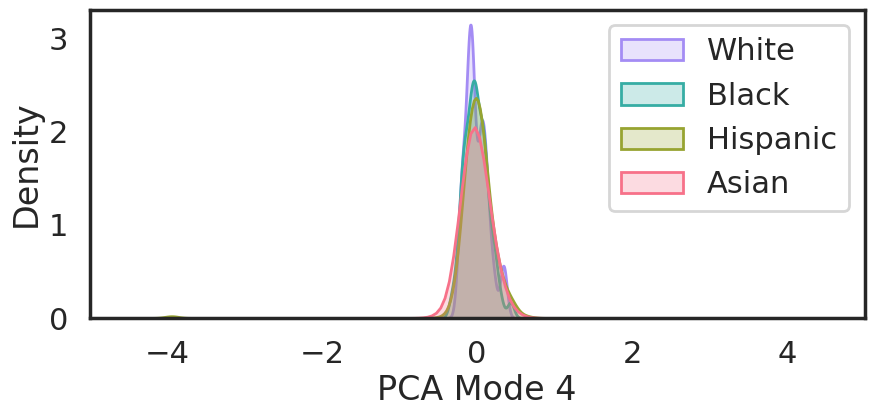

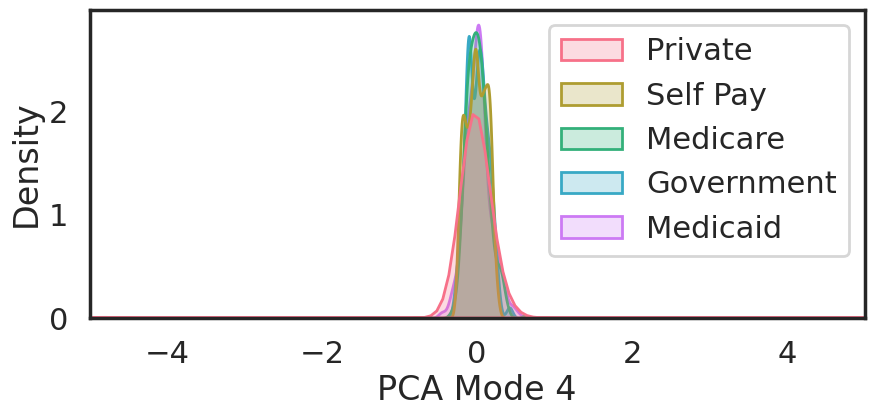

In [88]:
### PCA 2
xdat = 'PCA Mode 4'
label = "GENDER"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=['M', 'F'], data=sample_test_gender, ax=ax, common_norm=False)
g.get_legend().set_title(None)
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-4-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "AGE"
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.kdeplot(x=xdat, hue=label, fill=True, hue_order=[1, 0], data=sample_test_age, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["<65", "≥65"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-4-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "ETHNICITY"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_ethnicity.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True,
                hue_order=["WHITE", "BLACK/AFRICAN AMERICAN", "HISPANIC OR LATINO", "ASIAN"],
                data=sample_test_ethnicity, ax=ax, common_norm=False)
g.get_legend().set_title(None)
ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-4-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')

label = "INSURANCE"
fig, ax = plt.subplots(figsize=(10, 4))
sample_test_insurance.reset_index(inplace=True, drop=True)
g = sns.kdeplot(x=xdat, hue=label, fill=True, data=sample_test_insurance, ax=ax, common_norm=False)
g.get_legend().set_title(None)
# ax.legend(labels=["White", "Black", "Hispanic", "Asian"])
g.set_xlim(xlim)
plt.savefig(os.path.join("results", dataset, "marginals", "pca-4-{}-{}-marginal.pdf".format(model_name, label)),
            bbox_inches='tight')